Mount Google Drive to load models containing X-ray images in personal folder

In [3]:
# Get data form drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#import libraries and packages

from numpy.random import seed
seed(8) #1

import tensorflow
tensorflow.random.set_seed(7)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

from tensorflow.python.keras import models
from tensorflow.python.keras import layers

from tensorflow.keras import optimizers




In [5]:
print(os.listdir("/content/"))

#Print and remove zips once done



['.config', 'drive', 'sample_data']


**Crete Data Generators to preprocess and prepare training and validation**

*   Mục danh sách
*   Mục danh sách



In [6]:

from os import listdir

data_list = listdir('/content/drive/My Drive/DATASET/covid-19/four_classes/train')

#Delete some classes that may interfere

print(len(data_list))


DATASET_PATH  = '/content/drive/My Drive/DATASET/covid-19/four_classes/train'
test_dir =  '/content/drive/My Drive/DATASET/covid-19/four_classes/test'
IMAGE_SIZE    = (128, 128)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 80
LEARNING_RATE = 0.00001



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')



# For multiclass use categorical n for binary use binary
train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"   #For multiclass use categorical n for binary use binary
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"  #For multiclass use categorical n for binary use binary
                                                 
                                                  )



4


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1489 images belonging to 4 classes.
Found 370 images belonging to 4 classes.


In [7]:
path="/content/covid-19/four_classes/"
!ls -a /content/covid-19/four_classes/train/.ipynb_checkpoints
!rm -R /content/covid-19/four_classes/test/.ipynb_checkpoints 
!pwd

ls: cannot access '/content/covid-19/four_classes/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/covid-19/four_classes/test/.ipynb_checkpoints': No such file or directory
/content


Create a new model or Use Pre trained CNN Model and modify according to the need. 

In [8]:
#Simple CNN model based on Xception. Set dense layer neuron count same as the no. of output classes 
#If you wnna use a saved model then skip this step


# from tensorflow.keras.applications import Xception

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))


conv_base.trainable = True


model = models.Sequential()
model.add(conv_base)




model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy',     #for multiclass use categorical_crossentropy
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

80142336/80134624 [==============================] - 1s 0us/step


**Load an already saved model (If there is a trained model already saved on drive)**

In [9]:
#Load saved model from .hs file, otherwise disable this line
#model=load_model('/content/drive/My Drive/Colab Notebooks/4-class-Covid19-Mod-Xception.h5')
print(model.summary())
print("----------")
print(conv_base.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 22,122,820
Trainable params: 22,122,820
Non-trainable params: 0
_________________________________________________________________
None
----------
Model: "vgg19"
_________________________________________________________________
Layer (type) 

Training

In [10]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )



47
12
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/80
46/46 [==============================] - 755s 16s/step - loss: 1.3963 - acc: 0.3713 - val_loss: 1.1655 - val_acc: 0.4631
Epoch 2/80
46/46 [==============================] - 47s 1s/step - loss: 1.2439 - acc: 0.4427 - val_loss: 0.9811 - val_acc: 0.5284
Epoch 3/80
46/46 [==============================] - 47s 1s/step - loss: 1.0554 - acc: 0.5319 - val_loss: 0.9020 - val_acc: 0.5795
Epoch 4/80
46/46 [==============================] - 47s 1s/step - loss: 0.8692 - acc: 0.6170 - val_loss: 0.8011 - val_acc: 0.6619
Epoch 5/80
46/46 [==============================] - 47s 1s/step - loss: 0.7721 - acc: 0.6651 - val_loss: 0.6843 - val_acc: 0.7074
Epoch 6/80
46/46 [==============================] - 47s 1s/step - loss: 0.6621 - acc: 0.7076 - val_loss: 0.7597 - val_acc: 0.7102
Epoch 7/80
46/46 [==============================] - 47s 1s/step - loss: 0.6043 - acc: 0.7474 - val_loss: 0.6576 - val_acc: 0.7131
Epoch 8/80
46/46 [==============================] - 47s 1s/step - loss: 0.5374 - acc: 0.

Evaluation

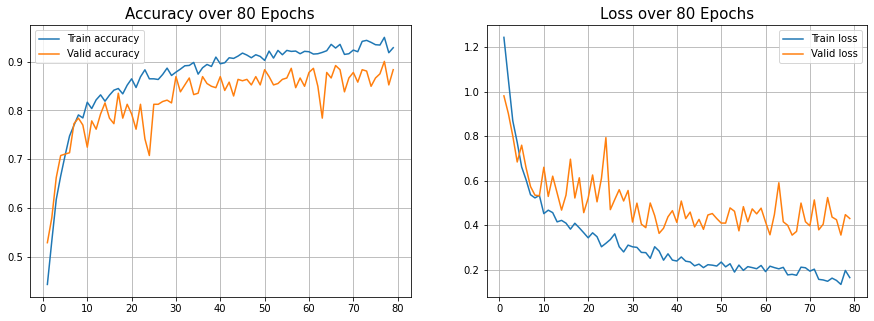

In [12]:
#Plot the accuracy and loss graphs

import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train accuracy')
    plt.plot(range(1,epochs), val_acc[1:], label='Valid accuracy')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Valid loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 80)

In [ ]:
#Save the trained model and copy to drive

model.save('4-class-Covid19-Mod-Xception.h5')
#!cp /content/"4-class-Covid19-Mod-Xception.h5" /content/drive/"My Drive"/"Colab Notebooks"


**Evaluate using evaluate Generator**

In [13]:
# Create evaluate data generator from test set
#Dont forget shuffle false

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  '/content/drive/My Drive/DATASET/covid-19/four_classes/test'
eval_generator = test_datagen.flow_from_directory(test_dir,target_size=IMAGE_SIZE,batch_size=1, 
                                                  shuffle=False, seed=42, class_mode="categorical")
eval_generator.reset()    


Found 280 images belonging to 4 classes.


In [14]:
#Evalute the trained model on evaluate generator
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#Poor test accuracy due to the small dataset size

Instructions for updating:
Please use Model.evaluate, which supports generators.
280/280 [==============================] - 130s 464ms/step - loss: 0.5048 - acc: 0.8929
Test loss: 0.5048151016235352
Test accuracy: 0.8928571343421936


**Create DataGen on single folder/class and predict !**

In [15]:
IMAGE_SIZE    = (128, 128)
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  '/content/drive/My Drive/DATASET/covid-19/four_classes/test'
pred_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        
        seed=42,
        
        class_mode="categorical")
pred_generator.reset()   

count=[0,0,0,0]

files=pred_generator.filenames

for i in range(len(files)):
  x,y = pred_generator.next()
  img = x
  predict=model.predict(img)
  
  p=np.argmax(predict, axis=-1)
  print(str(p[0])+" "+files[pred_generator.batch_index-1])
  #print(predict)
  #p=model.predict_classes(img)
  count[p[0]]+=1
  
#print(str(p[0])+" "+files[i]) 
print(count)
  


Found 280 images belonging to 4 classes.
0 covid/RX-torace-a-letto-del-paziente-in-unica-proiezione-AP-1-1.jpeg
0 covid/S1-new.png
0 covid/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day19.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day27.jpeg
0 covid/X-ray_of_cyst_in_pneumocystis_pneumonia_1.jpg
0 covid/radiol.2020201160.fig3b.jpeg
0 covid/radiol.2020201160.fig3c.jpeg
0 covid/radiol.2020201160.fig3d.jpeg
0 covid/radiol.2020201160.fig6b.jp

### **`Predict Results using predict generator and evaluate the accuracy and Confusion matrix `**

Instructions for updating:
Please use Model.predict, which supports generators.
[[34  1  0  0]
 [ 0 98  0  2]
 [ 0  5 61  9]
 [ 0  3 10 57]]
[[34  1  0  0]
 [ 0 98  0  2]
 [ 0  5 61  9]
 [ 0  3 10 57]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.92      0.98      0.95       100
           2       0.86      0.81      0.84        75
           3       0.84      0.81      0.83        70

    accuracy                           0.89       280
   macro avg       0.90      0.89      0.90       280
weighted avg       0.89      0.89      0.89       280



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


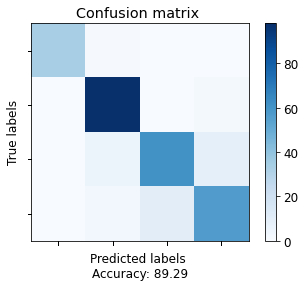

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report



filenames = eval_generator.filenames
nb_samples = len(filenames)
eval_generator.reset()  
predict = model.predict_generator(eval_generator,steps = np.ceil(len(eval_generator)))
pp=predict
predict=np.argmax(predict, axis=-1)
classes= eval_generator.classes[eval_generator.index_array]
acc=sum(predict==classes)/len(predict)
names=["covid","normal","pneumonia_bac","pneumonia_vir"]
print(confusion_matrix(classes,predict))

font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)
cm = confusion_matrix(classes, predict)
print(cm)
print(classification_report(classes,predict))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(acc*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()